# Sequence of analyzes Performed in This Notebook

1. Kernel Analysis
2. C and Epsilon Analysis
3. Gamma Analysis
4. Combines all the best parameters in one SVR model and plot the residual vs predicted value
5. Lag and Log transformation to minimize the Mean Absolute Error (MAE)

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error
import parse_data as ps
import descriptive as ds

# 1. LOAD DAN PREPARE DATA
df = ps.parse("Air_Quality_Data.csv")
df = ds.remove_outliers(df)

# Definition of Set E (The best set from classical.py analysis)
SET_E = {
    "Winter": ["dew point", "pressure", "wind speed", "temperature", "rainfall duration"],
    "Spring": ["dew point", "temperature", "pressure", "wind speed"],
    "Summer": ["dew point", "pressure", "rainfall duration", "temperature", "wind speed"],
    "Autumn": ["dew point", "temperature", "wind speed", "rainfall duration"]
}

---

# 1st Analysis: Kernel Analysis (Linear, Poly, Rbf, or Sigmoid)

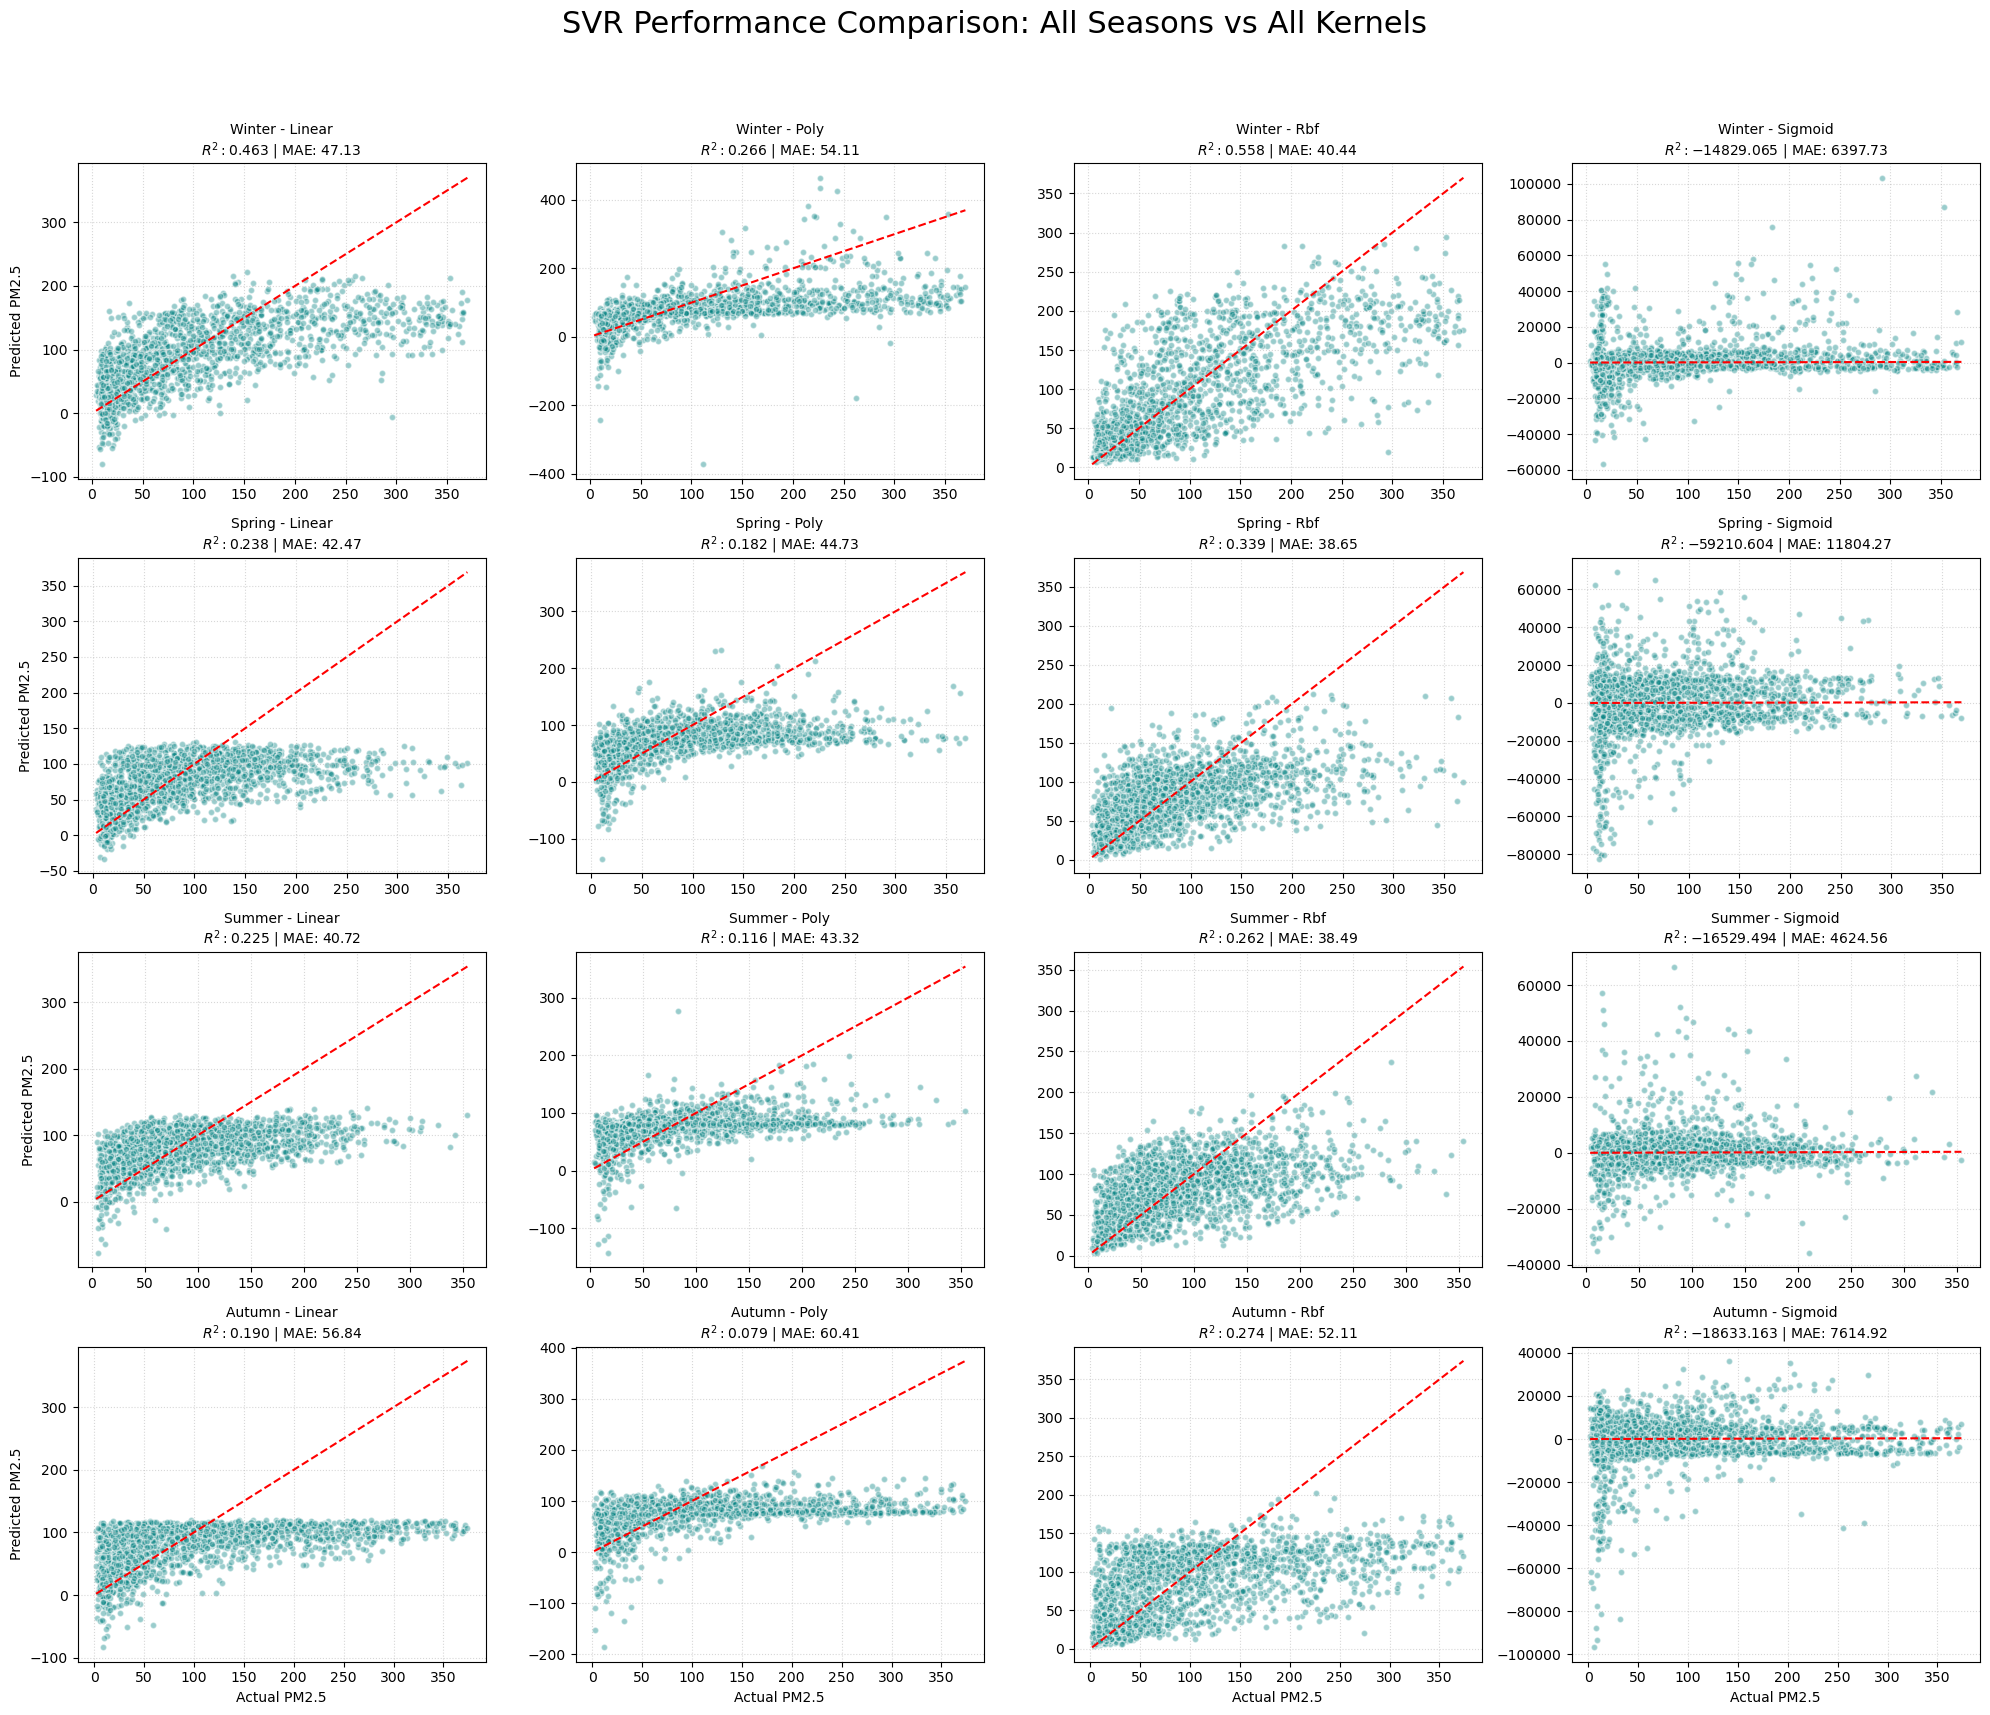

In [17]:
seasons = ["Winter", "Spring", "Summer", "Autumn"]
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Create the plot grid (4x4 grid for all seasons and kernels)
fig, axes = plt.subplots(len(seasons), len(kernels), figsize=(20, 18))

# --- MAIN ANALYSIS LOOP ---
for i, season in enumerate(seasons):
    # Filter data by season
    df_s = df[df["season"] == season].copy()
    features = SET_E[season]
    X = df_s[features].values
    y = df_s["concentration"].values
    
    # Split Data: 80% Training, 20% Testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scaling Features
    scaler_x = StandardScaler()
    X_train_scaled = scaler_x.fit_transform(X_train)
    X_test_scaled = scaler_x.transform(X_test)
    
    # Nested Loop: Iterate through each SVR kernel type
    for j, k in enumerate(kernels):
        # Initialize and Train SVR model
        # Using C=100 and epsilon=0.1 as per original setup
        model = svm.SVR(kernel=k, C=100, epsilon=0.1)
        model.fit(X_train_scaled, y_train)
        
        # Generate Predictions
        y_pred = model.predict(X_test_scaled)
        
        # Performance Evaluation Metrics
        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        
        # --- VISUALIZATION ---
        ax = axes[i, j]
        ax.scatter(y_test, y_pred, alpha=0.4, color='teal', edgecolors='white', s=20)
        
        # Draw the Ideal Prediction Line (1:1 relationship)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=1.5)
        
        # Formatting individual subplots
        ax.set_title(f"{season} - {k.capitalize()}\n$R^2: {r2:.3f}$ | MAE: {mae:.2f}", fontsize=10)
        
        # Add labels only to the outer edges to keep the plot clean
        if j == 0: 
            ax.set_ylabel("Predicted PM2.5")
        if i == 3: 
            ax.set_xlabel("Actual PM2.5")
            
        ax.grid(True, linestyle=':', alpha=0.5)
        
plt.suptitle("SVR Performance Comparison: All Seasons vs All Kernels", fontsize=22, y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Result of Kernel Analysis

- Model show better prediction by using Rbf kernel
- That is evidence by high R2 and low MAE than other kernel

----

# C and Epsilon Analysis 

- The C and Epsilon Analysis will used Rbf as kernel
- The value of C for this analysis are 1, 100, 1000
- The value of epsilon for this analysis are 1.0, 0.1, and 0.01
- The analysis is splitted for each season due to its complexity (the computer will run slowly if the analysis is made in loop)


### C and Epsilon Analysis for Winter Season

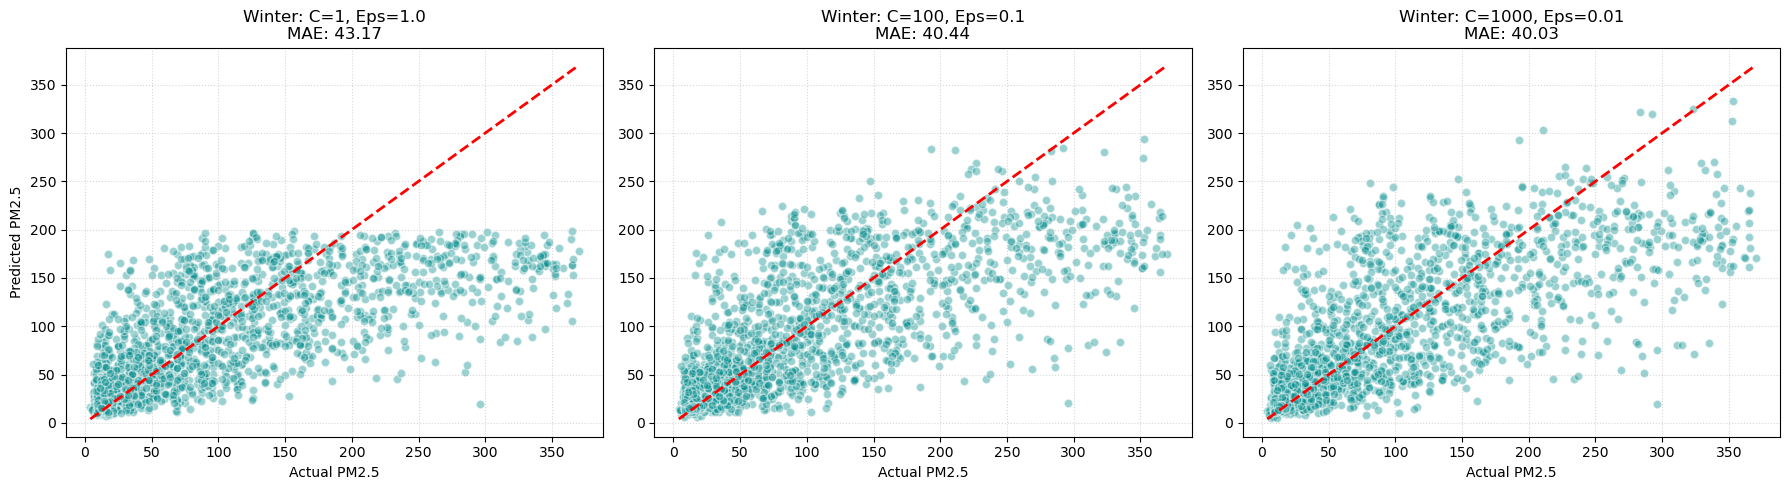

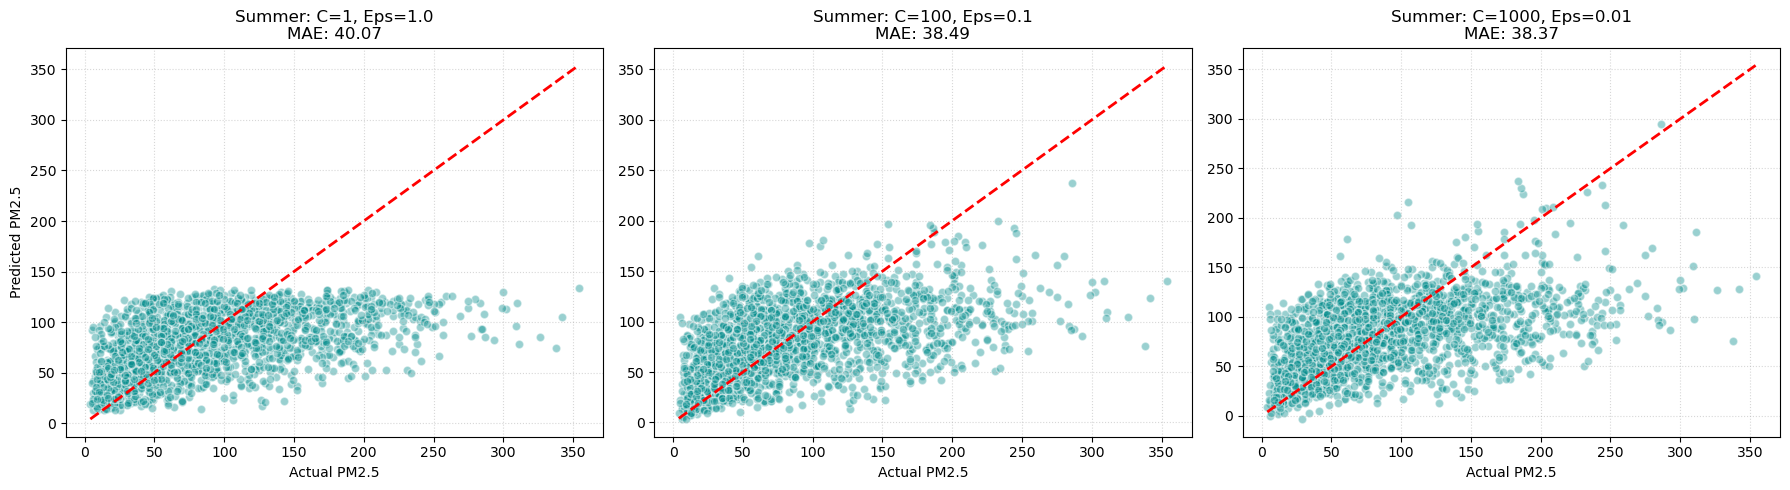

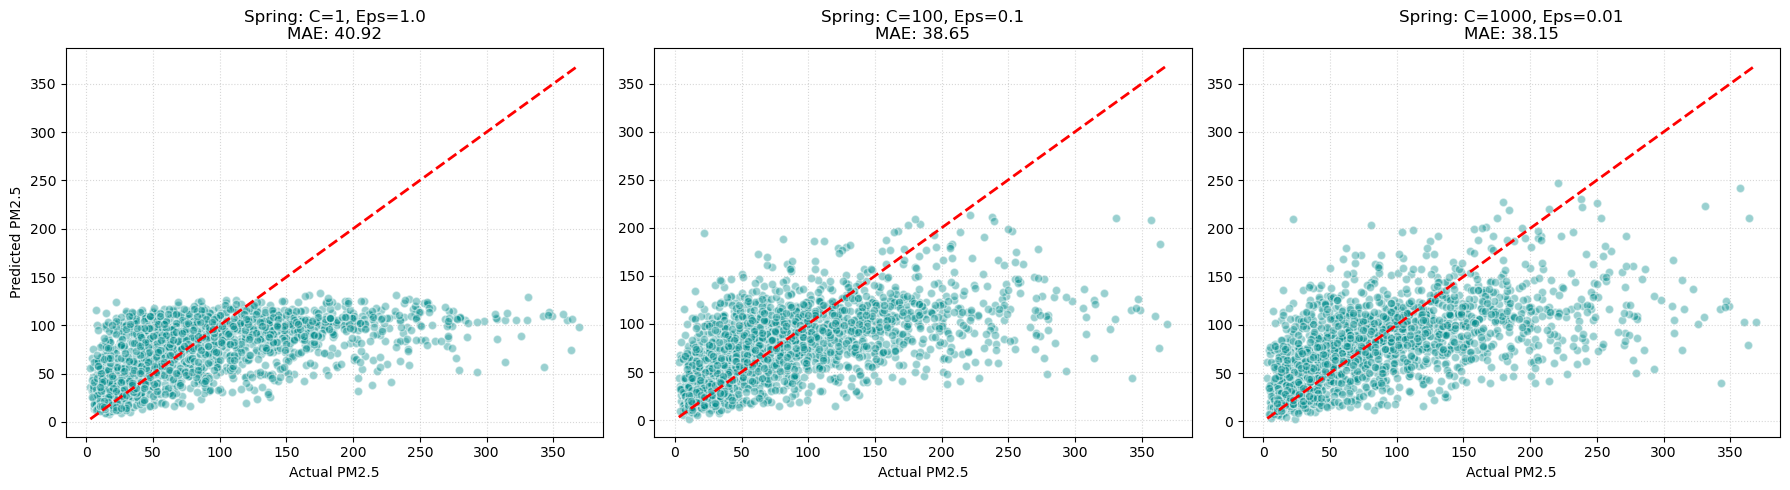

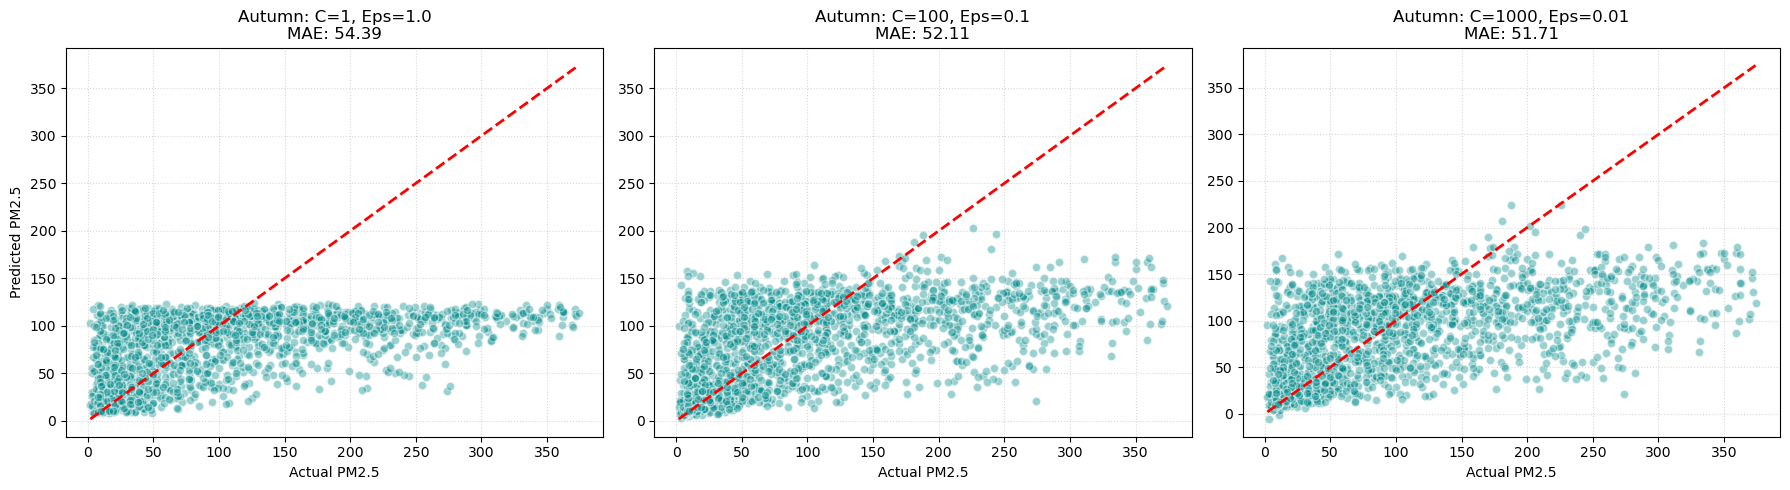

In [18]:
seasons_to_process = ["Winter", "Summer", "Spring", "Autumn"]
my_trials = [[1, 1.0], [100, 0.1], [1000, 0.01]]

# --- MAIN LOOP ---
for target_season in seasons_to_process:
    
    # 1. Filter Data by Season
    df_s = df[df["season"] == target_season].copy()
    features = SET_E[target_season]
    
    X = df_s[features].values
    y = df_s["concentration"].values

    # 2. Preprocessing: Split & Scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # 3. Setup Visualization for current Season
    fig, axes = plt.subplots(1, len(my_trials), figsize=(6 * len(my_trials), 5))
    
    # Ensure axes is iterable even if there is only 1 trial
    if len(my_trials) == 1:
        axes = [axes]

    # 4. Iterate through Parameter Trials (Hyperparameter Tuning)
    for j, (c_val, eps_val) in enumerate(my_trials):
        # Initialize and Train SVR Model
        model = svm.SVR(kernel='rbf', C=c_val, epsilon=eps_val)
        model.fit(X_train_s, y_train)
        
        # Generate Predictions
        y_pred = model.predict(X_test_s)
        
        # Performance Evaluation
        mae = mean_absolute_error(y_test, y_pred)

        # --- PLOTTING ---
        ax = axes[j]
        ax.scatter(y_test, y_pred, alpha=0.4, color='darkcyan', edgecolors='white')
        
        # Plot the 1:1 Ideal Line (Red dashed line)
        ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        
        # Formatting Subplots
        ax.set_title(f"{target_season}: C={c_val}, Eps={eps_val}\nMAE: {mae:.2f}")
        ax.set_xlabel("Actual PM2.5")
        
        # Only set Y-axis label for the first plot in the row to save space
        if j == 0: 
            ax.set_ylabel("Predicted PM2.5")
            
        ax.grid(True, linestyle=':', alpha=0.5)

    # Display plots for the current season before moving to the next
    plt.tight_layout()
    plt.show()

### Result of C and Epsilon Analysis

- A value of C=1000 is generally better for PM2.5 data (allows the model to capture non-linear patterns more effectively)
- An Epsilon=0.1 is preferred over 0.001 (it ignores small sensor noise, leading to better generalization)

---

# 3rd Analysis: Gamma Analysis

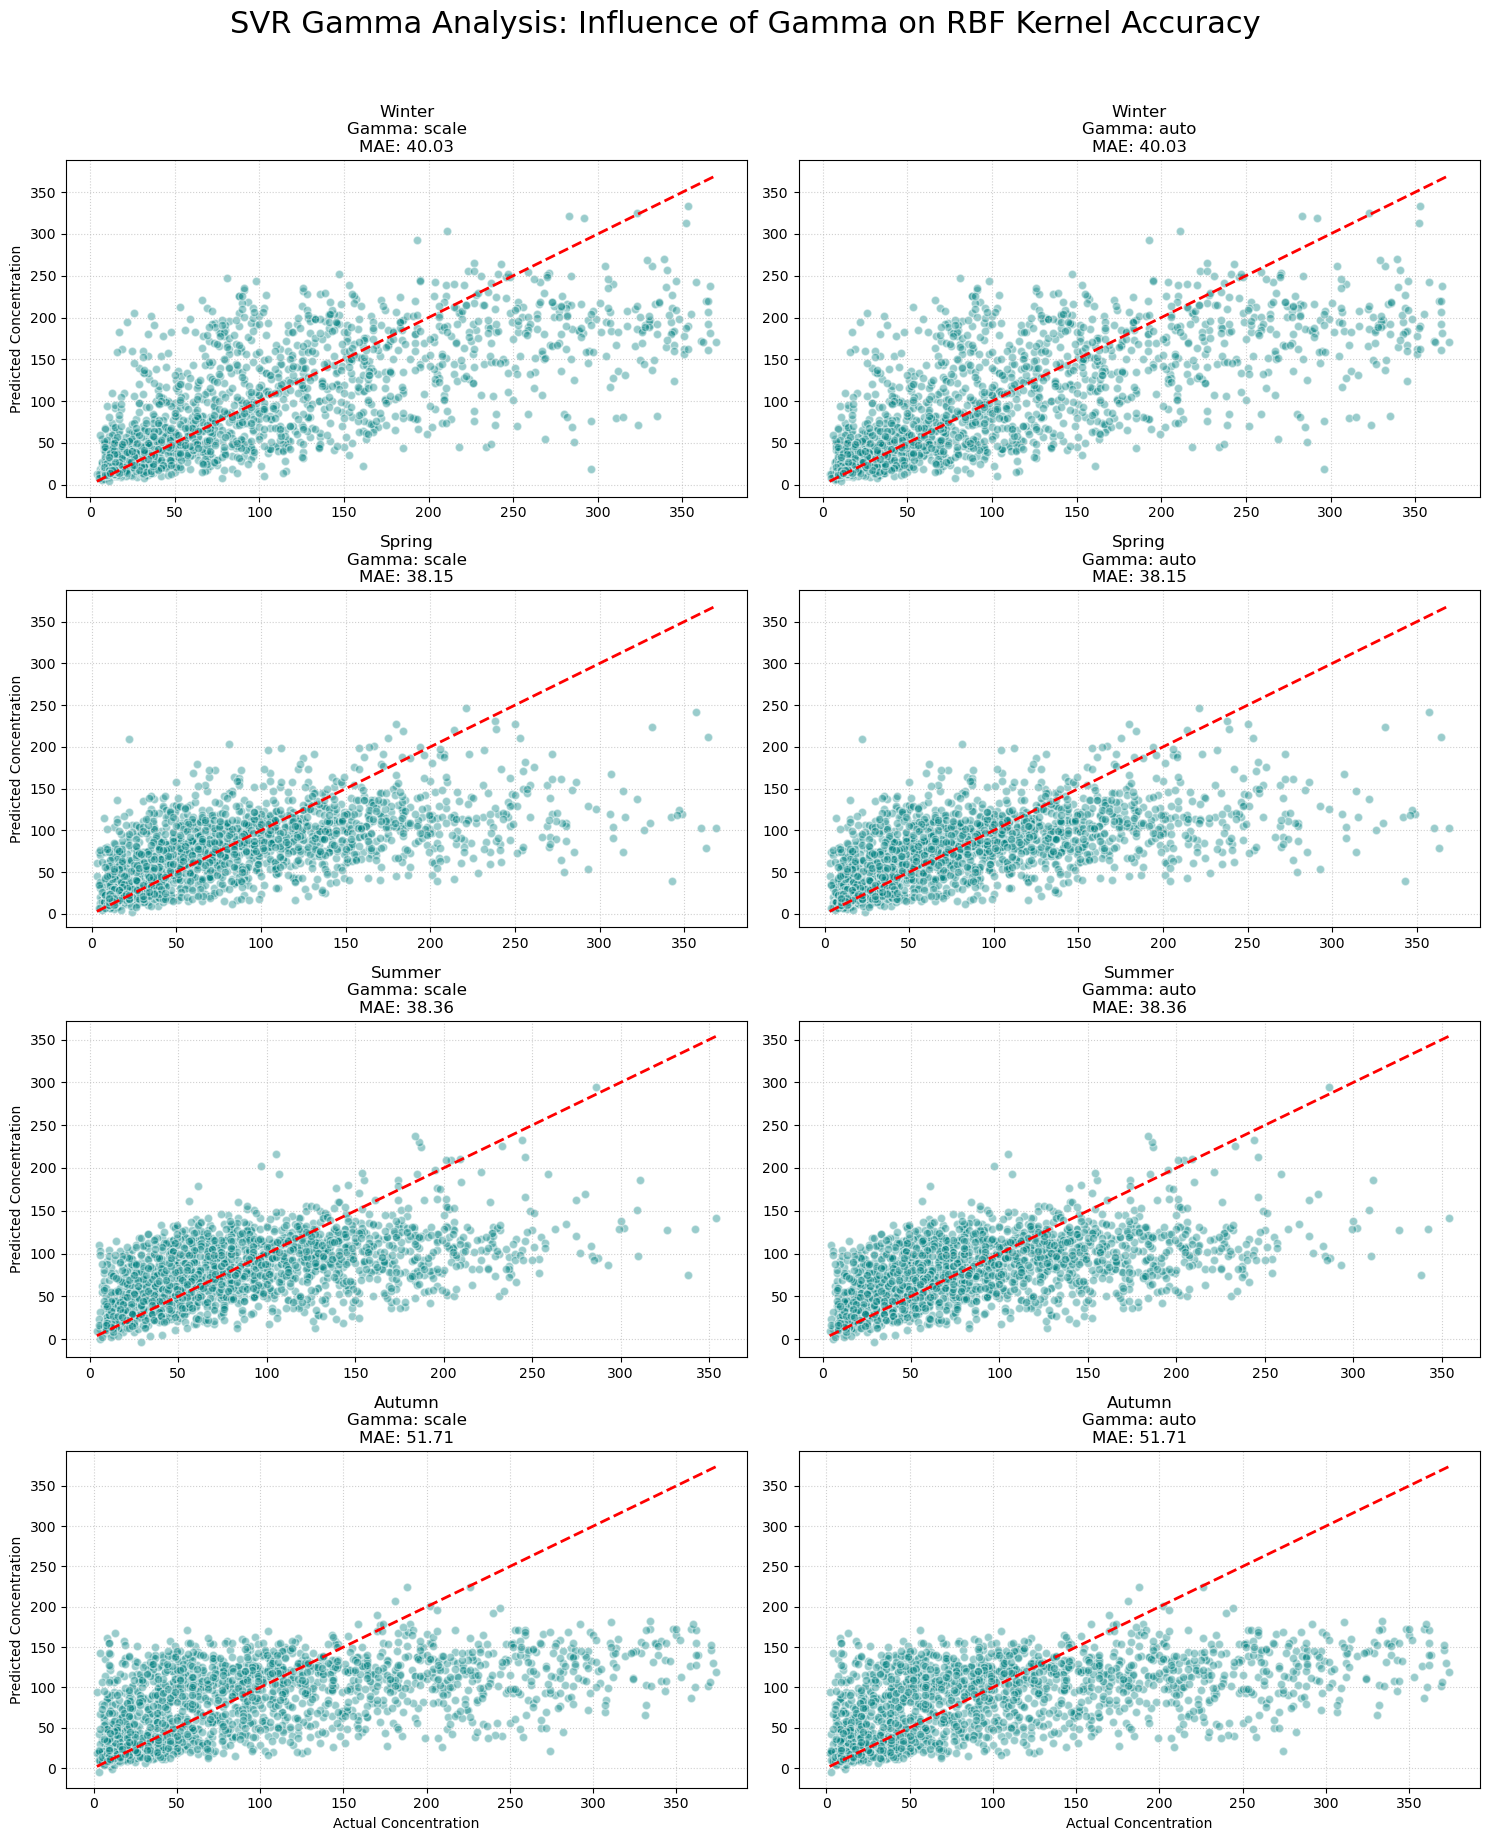

In [19]:
gamma_list = ['scale', 'auto']
season_list = ["Winter", "Spring", "Summer", "Autumn"]
features_dict = SET_E

# Initialize the plot grid (Rows = Seasons, Columns = Gamma values)
fig, axes = plt.subplots(len(season_list), len(gamma_list), figsize=(15, 18))

# --- MAIN ANALYSIS LOOP ---
for i, season in enumerate(season_list):
    
    # 1. Prepare Seasonal Data
    df_s = df[df["season"] == season].copy()
    features = features_dict[season]
    
    # Drop rows with missing values to prevent SVR errors
    df_s = df_s.dropna(subset=features + ["concentration"])
    
    X = df_s[features].values
    y = df_s["concentration"].values
    
    # 2. Split & Scaling
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # 3. Iterate through Gamma values
    for j, g in enumerate(gamma_list):
        # Initialize and Train SVR (using C=1000 and epsilon=0.1)
        model = svm.SVR(kernel='rbf', C=1000, epsilon=0.1, gamma=g)
        model.fit(X_train_s, y_train)
        
        # Generate Predictions
        y_pred = model.predict(X_test_s)
        
        # Calculate Performance Metric
        mae = mean_absolute_error(y_test, y_pred)
        
        # --- VISUALIZATION ---
        ax = axes[i, j]
        ax.scatter(y_test, y_pred, alpha=0.4, color='teal', edgecolors='white')
        
        # Draw the 1:1 Ideal Prediction Line
        min_val, max_val = y_test.min(), y_test.max()
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2)
        
        # Subplot Titles and Labels
        ax.set_title(f"{season}\nGamma: {g}\nMAE: {mae:.2f}")
        
        # Only show Y-label on the left-most column
        if j == 0: 
            ax.set_ylabel("Predicted Concentration")
        
        # Only show X-label on the bottom row
        if i == len(season_list) - 1: 
            ax.set_xlabel("Actual Concentration")
        
        ax.grid(True, linestyle=':', alpha=0.6)

# --- FINAL LAYOUT ADJUSTMENTS ---
plt.suptitle("SVR Gamma Analysis: Influence of Gamma on RBF Kernel Accuracy", fontsize=22, y=1.02)
plt.tight_layout()
plt.show()

### Result of gamma analysis

1. The results are identical because StandardScaler was applied to the model, forcing the variance ($X.var()$) of the data to be 1. It makes the mathematical formulas for both 'scale' and 'auto' yield the same value.
2. these results indicates that the preprocessing step has unified the feature scales, ensuring that the RBF kernel's sensitivity remains consistent regardless of the gamma calculation method used.

# 4th Analysis: Combine all selected parameter and generate residual plot

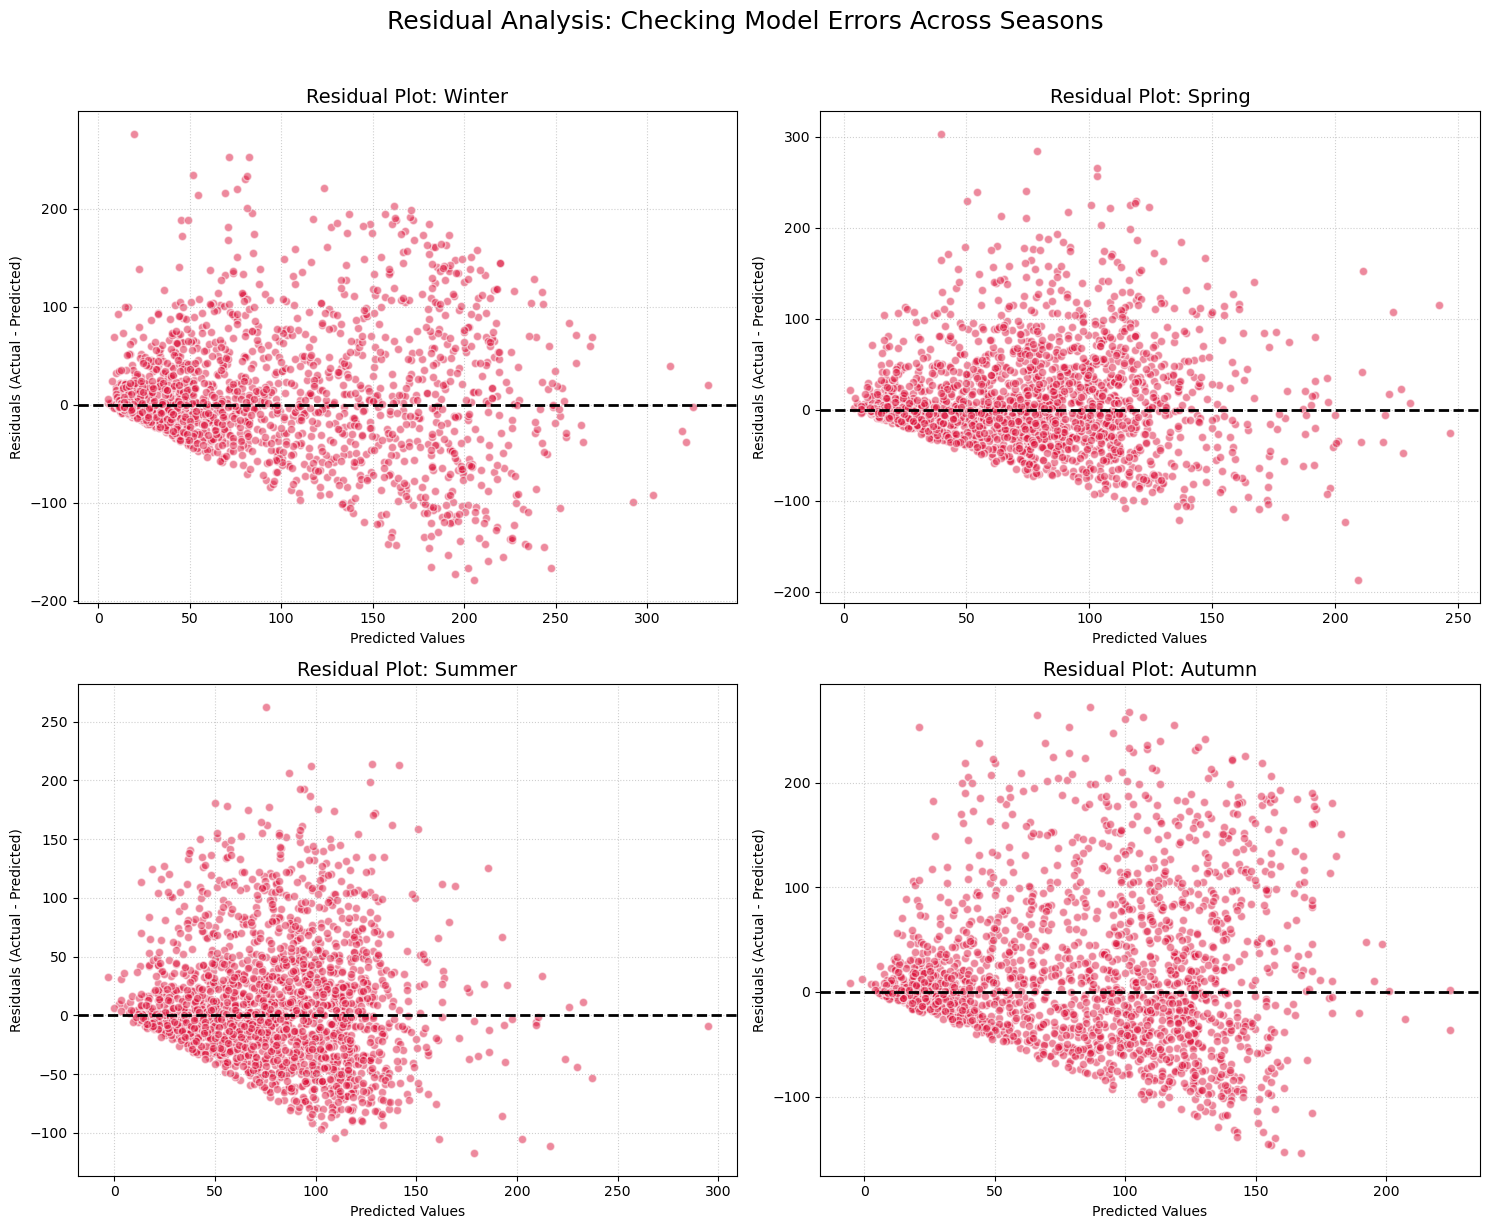

In [8]:
# Use predefined parameters
c_best = 1000
eps_best = 0.1
gamma_best = 'scale'
seasons = ["Winter", "Spring", "Summer", "Autumn"]

# Make the grid plot
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for i, season in enumerate(seasons):
    # Load and prepare data
    df_s = df[df["season"] == season].copy()
    X = df_s[SET_E[season]].values
    y = df_s["concentration"].values
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    scaler = StandardScaler()
    X_train_s = scaler.fit_transform(X_train)
    X_test_s = scaler.transform(X_test)

    # Fit the Model
    model = svm.SVR(kernel='rbf', C=c_best, epsilon=eps_best, gamma=gamma_best)
    model.fit(X_train_s, y_train)
    y_pred = model.predict(X_test_s)
    
    # Calculate the Residual
    residuals = y_test - y_pred
    
    # Plotting the Residuals
    ax = axes[i]
    ax.scatter(y_pred, residuals, alpha=0.5, color='crimson', edgecolors='white')
    ax.axhline(y=0, color='black', linestyle='--', lw=2) # Garis nol sebagai acuan
    
    ax.set_title(f"Residual Plot: {season}", fontsize=14)
    ax.set_xlabel("Predicted Values")
    ax.set_ylabel("Residuals (Actual - Predicted)")
    ax.grid(True, linestyle=':', alpha=0.6)

plt.suptitle("Residual Analysis: Checking Model Errors Across Seasons", fontsize=18, y=1.02)
plt.tight_layout()
plt.show()

### Result of Residual Analysis

1. Heteroscedasticity and Non-linear Patterns: The plots show a funnel shape where the spread of residuals increases with the predicted values, indicating heteroscedasticity

2. Persistent Underestimation/Overestimation: There is a visible curvature in the residuals, suggesting that the SVR model is failing to capture complex trends

3. Temporal Dependency and Autocorrelation: The residuals appear clustered, which is common in PM2.5 data where the concentration at one hour is highly dependent on the previous hour


**Solution to lower MAE and enhance the SVR model:**
1. Lag Analysis(adding previous time steps as features): incorporate the temporal "memory" into the model, accounting for the time-series nature of pollution.
2. Log Analysis: stabilizes variance and manages skewed data scales

---

# 5th Analysis: Lag and Log Transformation

### Plot regression to assess the lag and log transformation

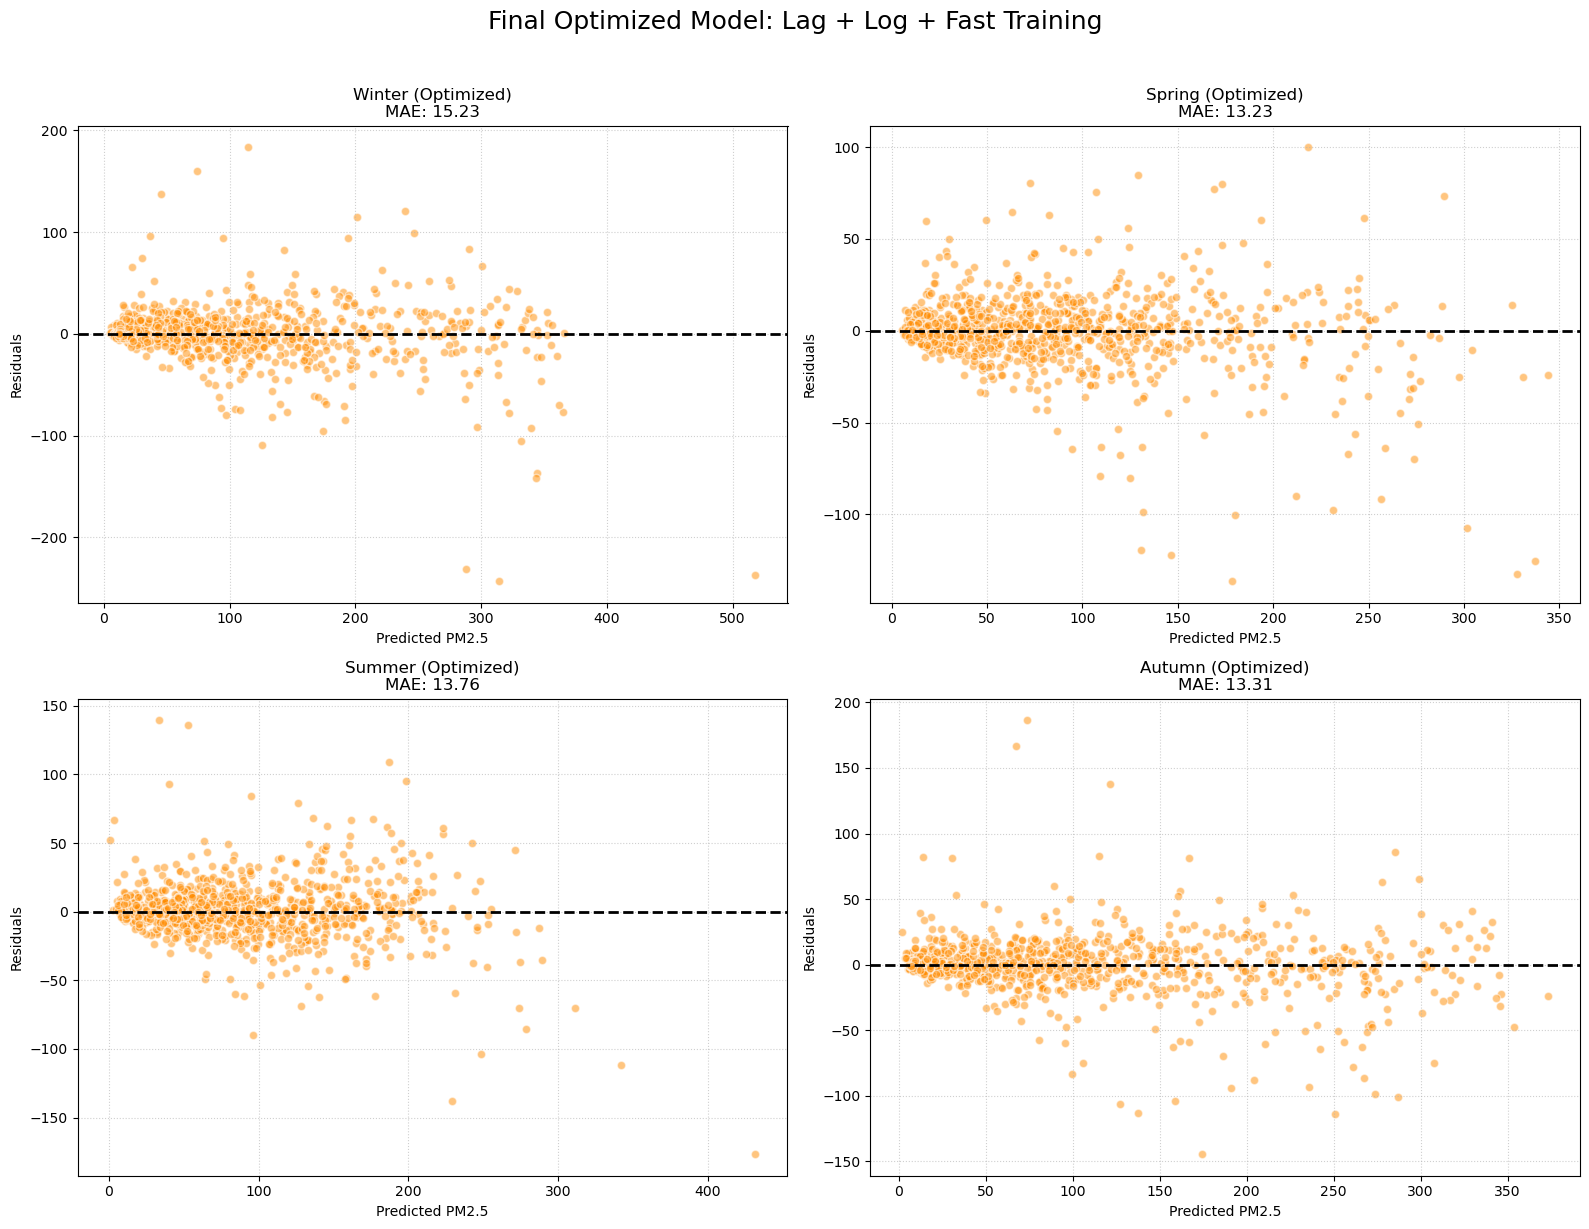

   Season    MAE
0  Winter  15.23
1  Spring  13.23
2  Summer  13.76
3  Autumn  13.31


In [9]:
def analyze_optimized_svr(df, seasons, features_dict, c_val=1000, eps_val=0.01, sample_size=5000):
    # Create the Lag-1 feature
    df_work = df.copy()
    df_work['lag_1'] = df_work['concentration'].shift(1)

    # Create df_final by dropping the first row (which is NaN)
    df_final = df_work.dropna(subset=['lag_1']).copy()

    # Setup Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    optimized_summary = []

    # Modelling Loop
    for i, season in enumerate(seasons):
        # Filter data per season
        df_s = df_final[df_final["season"] == season].copy()
        
        # Data sampling for better run speed 
        if len(df_s) > sample_size:
            df_s = df_s.sample(n=sample_size, random_state=42)
        
        # Ensure Lag_1 feature are available for each season
        current_features = features_dict[season].copy()
        if 'lag_1' not in current_features:
            current_features.append('lag_1')
        
        X = df_s[current_features].values
        y = df_s["concentration"].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        # Log Transformation
        y_train_log = np.log1p(y_train)
        
        # SVR with High Cache
        model = svm.SVR(
            kernel='rbf', 
            C=c_val, 
            epsilon=eps_val, 
            cache_size=1500
        )
        
        model.fit(X_train_s, y_train_log)
        
        # Prediction and Inverse Log
        y_pred_log = model.predict(X_test_s)
        y_pred_final = np.expm1(y_pred_log)
        
        mae = mean_absolute_error(y_test, y_pred_final)
        residuals = y_test - y_pred_final
        optimized_summary.append({"Season": season, "MAE": round(mae, 2)})

        # Plotting
        ax = axes[i]
        ax.scatter(y_pred_final, residuals, alpha=0.5, color='darkorange', edgecolors='white')
        ax.axhline(y=0, color='black', linestyle='--', lw=2)
        ax.set_title(f"{season} (Optimized)\nMAE: {mae:.2f}")
        ax.set_xlabel("Predicted PM2.5")
        ax.set_ylabel("Residuals")
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.suptitle("Final Optimized Model: Lag + Log + Fast Training", fontsize=18, y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Return summary 
    return pd.DataFrame(optimized_summary)

seasons_list = ["Winter", "Spring", "Summer", "Autumn"]
summary_df = analyze_optimized_svr(df, seasons_list, SET_E)
print(summary_df)

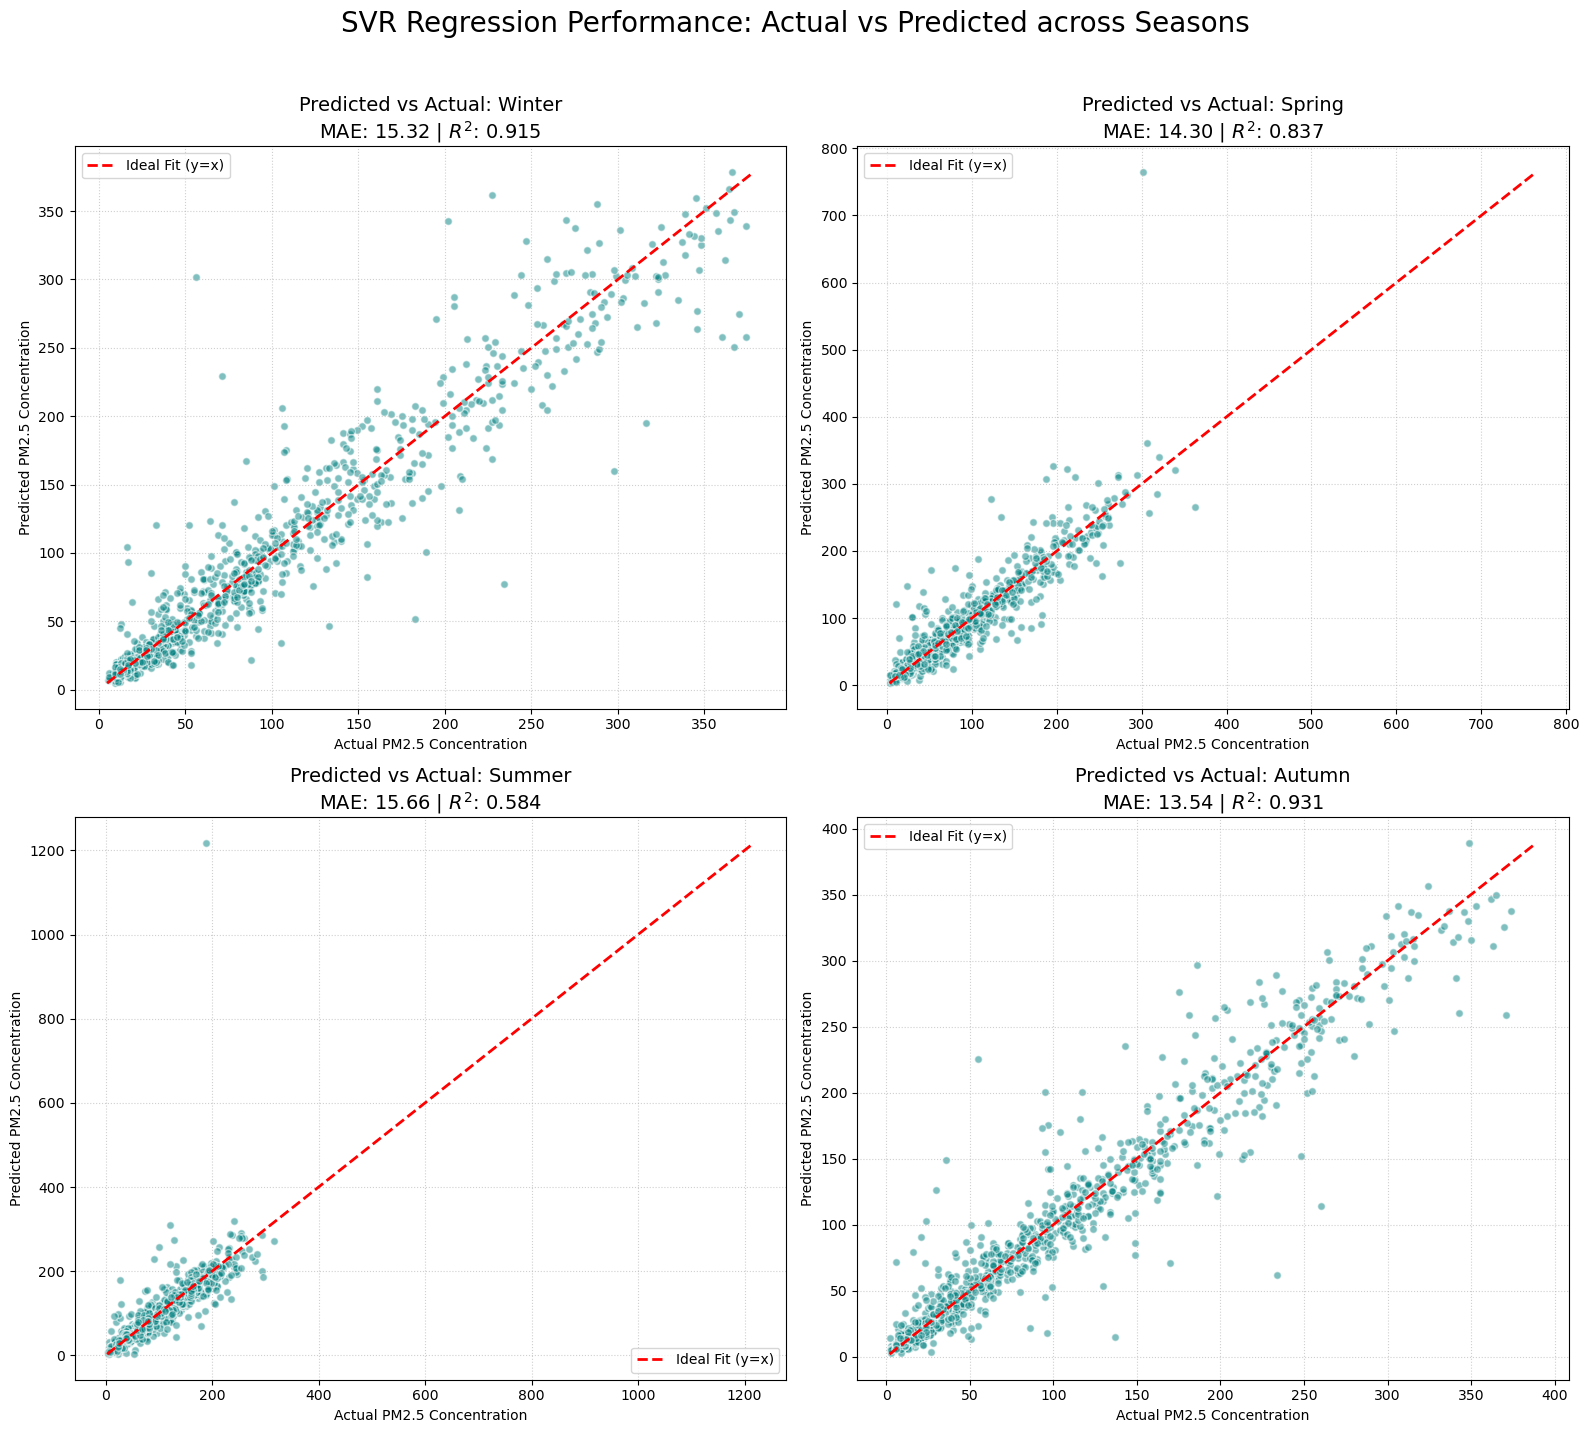


--- Final Performance Summary ---


Season    MAE     R2
0  Winter  15.32  0.915
1  Spring  14.30  0.837
2  Summer  15.66  0.584
3  Autumn  13.54  0.931

In [12]:
def analyze_final_svr_performance(df, seasons, features_dict, c_val=1000, eps_val=0.01, sample_size=5000):
    df_work = df.copy() 
    df_work.columns = df_work.columns.str.lower() # Memastikan kolom huruf kecil
    
    # Create the Lag-1 feature
    df_work['lag_1'] = df_work['concentration'].shift(1)
    df_final = df_work.dropna(subset=['lag_1']).copy()

    # Setup Plot
    fig, axes = plt.subplots(2, 2, figsize=(16, 14))
    axes = axes.flatten()
    final_results = []

    # Modelling Loop 
    for i, season in enumerate(seasons):
        # Filter & Sampling
        df_s = df_final[df_final["season"] == season].copy()
        if len(df_s) > sample_size:
            df_s = df_s.sample(n=sample_size, random_state=42)
        
        # Ensure Lag_1 feature are available for each season
        current_features = features_dict[season].copy()
        if 'lag_1' not in current_features:
            current_features.append('lag_1')
        if 'hour' in df_final.columns and 'hour' not in current_features:
            current_features.append('hour')
            
        X = df_s[current_features].values
        y = df_s["concentration"].values
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        scaler = StandardScaler()
        X_train_s = scaler.fit_transform(X_train)
        X_test_s = scaler.transform(X_test)

        # Log Transformation
        y_train_log = np.log1p(y_train)
        
        # SVR Training
        model = svm.SVR(kernel='rbf', C=c_val, epsilon=eps_val, cache_size=1500)
        model.fit(X_train_s, y_train_log)
        
        # Prediction & Inverse Log
        y_pred_log = model.predict(X_test_s)
        y_pred_final = np.expm1(y_pred_log)
        
        # Metrics
        mae = mean_absolute_error(y_test, y_pred_final)
        r2 = r2_score(y_test, y_pred_final)
        final_results.append({"Season": season, "MAE": round(mae, 2), "R2": round(r2, 3)})

        # Plotting
        ax = axes[i]
        ax.scatter(y_test, y_pred_final, alpha=0.5, color='teal', edgecolors='white', s=30)
        
        # Ideal Line (y=x)
        max_val = max(y_test.max(), y_pred_final.max())
        min_val = min(y_test.min(), y_pred_final.min())
        ax.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', lw=2, label='Ideal Fit (y=x)')
        
        ax.set_title(f"Predicted vs Actual: {season}\nMAE: {mae:.2f} | $R^2$: {r2:.3f}", fontsize=14)
        ax.set_xlabel("Actual PM2.5 Concentration")
        ax.set_ylabel("Predicted PM2.5 Concentration")
        ax.legend()
        ax.grid(True, linestyle=':', alpha=0.6)

    plt.suptitle("SVR Regression Performance: Actual vs Predicted across Seasons", fontsize=20, y=1.02)
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(final_results)

seasons_list = ["Winter", "Spring", "Summer", "Autumn"]
summary_df = analyze_final_svr_performance(df, seasons_list, SET_E)
print("\n--- Final Performance Summary ---")
display(summary_df)

### Result of Lag and Log Transformation

1. Significant Improvement in Accuracy: By applying Lag and Log Analysis, the model now predicts PM2.5 levels with better precision across all seasons
2. The current model corrected the "funnel-shaped" error pattern from previous analysis where predictions became less reliable at high concentrations